# Self-Instruction Dataset Creation Example

This notebook demonstrates how to create a dataset for fine-tuning language models using the Self-Instruction process, focusing on two task types: Sentiment Analysis and Question Answering (QA).

The main steps of the Self-Instruction process are as follows:
1. Prepare a small set of seed tasks  
2. Use a large language model to generate additional tasks  
3. Generate corresponding responses using the model  
4. Filter and clean the generated data  
5. Organize the final dataset for fine-tuning use  

In [ ]:
# Install packages
!pip install pandas tqdm numpy requests ollama matplotlib seaborn

## 1. Set Up the Environment and Import Necessary Libraries

In [ ]:
import ollama
import json
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
# import openai
import re
from datetime import datetime
from IPython.display import display, HTML

# Set you OpenAI Key
# openai.api_key = "YOUR_OPENAI_API_KEY"

model = "gemma3:4b"

# Set the random seed to ensure reproducibility.
random.seed(88)
np.random.seed(88)

## 2. We will create two types of seed tasks:
- Sentiment Analysis
- Question Answering (QA)

In [3]:
# Sentiment Analysis Seed Tasks
sentiment_seed_tasks = [
    {
        "instruction": "Analyze the sentiment of the following review and determine whether it is positive, negative, or neutral. Provide your reasoning.",
        "input": "The food at this restaurant was incredibly delicious, but the service was terrible—we waited an hour to be served.",
        "output": "This review contains mixed sentiments. The positive aspect praises the food, while the negative aspect criticizes the slow and poor service. Overall, the review leans negative, as the service issues seem to have significantly impacted the dining experience."
    },
    {
        "instruction": "Determine the sentiment tendency (positive, negative, or neutral) of the following text.",
        "input": "The visual effects of the movie were stunning, but the plot was slow and lacked creativity.",
        "output": "Negative. While the review acknowledges the movie’s visual appeal, the criticism of the plot is more significant, resulting in an overall negative impression."
    },
    {
        "instruction": "Analyze the sentiment tone of this passage and categorize it as positive, negative, or neutral.",
        "input": "The weather today is sunny and mild—perfect for outdoor activities.",
        "output": "Positive. The description conveys pleasant weather conditions, expresses satisfaction, and suggests that the weather is ideal for being outdoors—overall a positive sentiment."
    },
    {
        "instruction": "Determine the sentiment expressed in the following social media post.",
        "input": "Another ordinary workday, same routine as usual, nothing special.",
        "output": "Neutral. This post describes a routine day without expressing joy or dissatisfaction, reflecting a neutral emotional tone."
    },
    {
        "instruction": "Analyze the following product review and determine the user’s sentiment toward the product.",
        "input": "This phone has excellent battery life—it lasts a full two days on a single charge! The interface is also very intuitive. The camera is just average, but considering the price, I'm very satisfied.",
        "output": "Positive. The review highlights strong points like long battery life and user-friendly interface. While it notes that the camera is average, the overall evaluation is positive, especially considering the price, showing clear positive sentiment."
    }
]

# QA Seed Tasks
qa_seed_tasks = [
    {
        "instruction": "Answer the question based on the following paragraph.",
        "input": "The solar system consists of the Sun and the celestial bodies that orbit it, including planets, moons, asteroids, and comets. There are eight major planets in order from the Sun: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune. Among them, Jupiter is the largest, and Earth is the only one known to support life.\n\nQuestion: Which planet is the largest in the solar system?",
        "output": "Jupiter is the largest planet in the solar system."
    },
    {
        "instruction": "Read the following and answer the question.",
        "input": "Coffee is a beverage made from coffee beans and is known for its stimulating effect, mainly due to its caffeine content. Originating from the Ethiopian highlands, coffee later spread around the world. Today, the leading coffee-producing countries include Brazil, Vietnam, and Colombia. Common brewing methods include drip, espresso, French press, and cold brew.\n\nQuestion: Why does coffee have a stimulating effect?",
        "output": "Coffee has a stimulating effect mainly because it contains caffeine."
    },
    {
        "instruction": "Answer the following history question.",
        "input": "World War I began in 1914, primarily triggered by the assassination of Archduke Franz Ferdinand of Austria-Hungary in Sarajevo. This event led Austria-Hungary to declare war on Serbia. Due to complex alliances, most major European nations were drawn into the conflict. The war ended in 1918 with a victory for the Allies and defeat for the Central Powers.\n\nQuestion: In what year did World War I begin?",
        "output": "World War I began in 1914."
    },
    {
        "instruction": "Answer the following question based on the provided information.",
        "input": "The human digestive system is made up of several organs, including the mouth, esophagus, stomach, small intestine, large intestine, liver, and pancreas. Digestion begins in the mouth, where food is chewed and mixed with saliva. It then travels down the esophagus to the stomach, where it is further broken down by stomach acid. Most nutrients are absorbed in the small intestine, while undigested waste moves into the large intestine and is eventually excreted.\n\nQuestion: Where are most nutrients absorbed in the human body?",
        "output": "Most nutrients in the human body are absorbed in the small intestine."
    },
    {
        "instruction": "Read the following article excerpt and answer the question.",
        "input": "Artificial Intelligence (AI) refers to intelligence demonstrated by machines, in contrast to natural intelligence shown by humans and animals. Modern AI technology primarily includes machine learning (especially deep learning), natural language processing, and computer vision. In recent years, AI has made significant advances in areas such as medical diagnosis, autonomous driving, and voice assistants, while also raising ethical concerns about privacy, employment, and safety.\n\nQuestion: What are the main areas included in modern AI technology?",
        "output": "Modern AI technology mainly includes machine learning (especially deep learning), natural language processing, and computer vision."
    }
]

for task in sentiment_seed_tasks:
    task['task_type'] = "sentiment"
for task in qa_seed_tasks:
    task['task_type'] = "qa"
# Combine All Seed Tasks
seed_tasks = sentiment_seed_tasks + qa_seed_tasks

# Display Task Counts
print(f"Number of Sentiment Analysis Seed Tasks: {len(sentiment_seed_tasks)}")
print(f"Number of QA Seed Tasks: {len(qa_seed_tasks)}")
print(f"Total Number of Seed Tasks: {len(seed_tasks)}")


Number of Sentiment Analysis Seed Tasks: 5
Number of QA Seed Tasks: 5
Total Number of Seed Tasks: 10


## 3. Define Functions to Generate New Task Instructions

In [4]:
def generate_instruction(task_type, existing_instructions, max_retries=5):
    """
    Generate a new task instruction using a large language model.
    
    Args:
        task_type: 'sentiment' or 'qa'
        existing_instructions: list of existing instructions to avoid duplication
        max_retries: maximum number of retry attempts
    
    Returns:
        A dictionary containing the newly generated instruction
    """
    # Select the appropriate prompt template based on the task type
    if task_type == "sentiment":
        prompt_template = """
        You are an AI assistant helping to create a sentiment analysis dataset.
        Please generate 5 new and diverse sentiment analysis instructions. 
        These instructions should ask users to determine the sentiment of a given text.

        Here are some examples of existing instructions:
        {examples}

        Now generate new instructions that are different from the examples above.
        Each instruction should clearly ask for sentiment classification.
        The available classes are: positive, negative, and neutral.
        
        Return the result in JSON format, with each item being just the instruction text 
        (no input/output examples):
        [
            {{"Instruction": "content number 1"}},
            {{"Instruction": "content number 2"}},
            ...
        ]
        """
        examples = "\n".join([f"- {task['instruction']}" for task in sentiment_seed_tasks])

    elif task_type == "qa":
        prompt_template = """
        You are an AI assistant helping to create a question-answering (QA) dataset.
        Please generate 5 new and diverse QA instructions. These should prompt users to answer questions based on a given context.

        Here are some examples of existing instructions:
        {examples}

        Now generate new instructions that differ from the examples above.
        Each instruction should clearly ask for a context-based answer.

        Return the result in JSON format, with each item being just the instruction text (no input/output examples):
        [
            {{"Instruction": "content number 1"}},
            {{"Instruction": "content number 2"}},
            ...
        ]
        """
        examples = "\n".join([f"- {task['instruction']}" for task in qa_seed_tasks])

    else:
        raise ValueError(f"Unsupported task type: {task_type}")

    prompt = prompt_template.format(examples=examples)

    np.random.seed(int(time.time()))    # Attempt to generate input content
    # Attempt to generate new instructions
    for attempt in range(max_retries):
        try:
            response = ollama.generate(
                model = model,
                prompt= prompt,
                options={
                    "temperature": 1.0,
                    "seed": np.random.randint(0, 10000),
                }
            )
            
            content = response['response'].strip()
            json_match = re.search(r'\[.*\]', content, re.DOTALL)
            if json_match:
                content = json_match.group(0)
            new_instructions = json.loads(content)

            if not isinstance(new_instructions, list):
                print(f"Attempt {attempt+1}/{max_retries}: Invalid return format, retrying...")
                continue
                      
            if isinstance(new_instructions[0], dict):
                if "Instruction" in new_instructions[0]:
                    new_instructions = [instr["Instruction"] for instr in new_instructions]                    
                else:
                    print(f"Attempt {attempt+1}/{max_retries}: Invalid return format, retrying...")
                    continue
            
            filtered_instructions = [instr for instr in new_instructions 
                                     if instr not in existing_instructions]

            if not filtered_instructions:
                print(f"Attempt {attempt+1}/{max_retries}: All generated instructions already exist, retrying...")
                continue

            selected_instruction = random.choice(filtered_instructions)
            return {"instruction": selected_instruction, "task_type": task_type}, prompt

        except Exception as e:
            print(f"Attempt {attempt+1}/{max_retries} failed: {e}")
            if attempt == max_retries - 1:
                raise
            time.sleep(2)  # Pause briefly before retrying

    raise Exception("Failed to generate new instruction after maximum retries.")


In [5]:
#Test: generate instruction
new_instruction_info, prompt = generate_instruction("sentiment", [])
output = f"""
<span style='color: white; background-color: purple'>Prompt Template</span><br>
<pre>{prompt}</pre>
<span style='color: black; background-color: yellow'>Instruction</span><br>
<pre>{new_instruction_info}</pre>
"""
display(HTML(output))

## 4. Define Functions to Generate Input Content

In [6]:
def generate_input(task_instruction, task_type, max_retries=5):
    """
    Generate input content based on a task instruction.
    
    Args:
        task_instruction: The task instruction text
        task_type: 'sentiment' or 'qa'
        max_retries: Maximum number of retry attempts
        
    Returns:
        Generated input content
    """
    # Select the appropriate prompt template based on the task type
    if task_type == "sentiment":
        prompt_template = """
        You are an AI assistant helping to create a sentiment analysis dataset. Given the following task instruction:

        "{instruction}"

        Please generate a suitable input text for this instruction. 
        The input should be a short passage requiring sentiment analysis related to {type}.

        The input text should:
        1. Be of moderate length (50–200 characters)
        2. Sound natural and realistic
        3. Convey a clear {sentiment_class} sentiment

        Return only the input text itself—no explanations or additional formatting. No double quotes.
        """

    elif task_type == "qa":
        prompt_template = """
        You are an AI assistant helping to create a question-answering (QA) dataset. Given the following QA instruction:

        "{instruction}"

        Please generate a suitable input. The input should include:
        1. A context paragraph rich in information (100–300 characters)
        2. A question that can be clearly answered based on the provided context

        The context can be related to science, history, culture, technology, health, or any other domain. The question must be directly answerable from the context.

        Format your output as follows:
        [Context paragraph]

        Question: [Your question here]

        Ensure that the question has a clear and direct answer in the context.
        """
    else:
        raise ValueError(f"Unsupported task type: {task_type}")

    prompt = prompt_template.format(
        instruction=task_instruction,
        sentiment_class = random.choice(["positive", "negative", "neutral"]),
        type=random.choice(["social connection", "product", "weather", "sports", "investment", "school life",
                            "book reading", "art critic", "traffic"])
    )

    np.random.seed(int(time.time()))    
    # Attempt to generate input content
    for attempt in range(max_retries):
        try:
            response = ollama.generate(
                model = model,
                prompt= prompt,
                options={
                    "temperature": 1.0,
                    "seed": np.random.randint(0, 10000),
                }
            )
            
            content = response['response'].strip().strip('"')

            # Basic validation
            if len(content) < 20:
                print(f"Attempt {attempt+1}/{max_retries}: Input too short, retrying...")
                continue

            if task_type == "qa" and "Question:" not in content:
                print(f"Attempt {attempt+1}/{max_retries}: Missing question part in QA input, retrying...")
                continue

            return content, prompt

        except Exception as e:
            print(f"Attempt {attempt+1}/{max_retries} failed: {e}")
            if attempt == max_retries - 1:
                raise
            time.sleep(2)

    raise Exception("Failed to generate input content after maximum retries.")


In [11]:
#Test: generate input
new_instruction_info, _ = generate_instruction("sentiment", [])
new_instruction = new_instruction_info["instruction"]
task_input, prompt = generate_input(new_instruction, "sentiment")
output = f"""
<span style='color: white; background-color: purple'>&nbsp;Prompt Template&nbsp;</span><br>
<pre>{prompt}</pre>
<span style='color: black; background-color: yellow'>&nbsp;Instruction&nbsp;</span><br>
<pre>{new_instruction_info}</pre>
<span style='color: black; background-color: cyan'>&nbsp;Input&nbsp;</span><br>
<pre>{task_input}</pre>
"""
display(HTML(output))

## 5. Define Functions to Generate Output Responses

In [12]:
def generate_output(task_instruction, task_input, task_type, max_retries=5):
    """
    Generate output response based on the instruction and input.
    
    Args:
        task_instruction: Task instruction text
        task_input: Input content for the task
        task_type: 'sentiment' or 'qa'
        max_retries: Maximum number of retry attempts
        
    Returns:
        Generated output response
    """
    # Choose an appropriate prompt template based on task type
    if task_type == "sentiment":
        prompt_template = """
        You are a professional sentiment analysis assistant. Based on the following instruction and input, generate a response:

        Instruction:
        {instruction}

        Input Text:
        {input}

        Please provide a concise, professional sentiment analysis result that meets the requirements of the instruction. The response should clearly indicate the sentiment (positive, negative or neutral) and briefly explain the reasoning.

        Return only the sentiment result as JSON object. Do not repeat the instruction or input text.
        {{
            "Sentiment": "positive",
            "Reason": "the reason for the judgement."
        }}
        """

    elif task_type == "qa":
        prompt_template = """
        You are a professional question-answering assistant. Based on the following instruction and input, generate a response:

        Instruction:
        {instruction}

        Input:
        {input}

        Please provide a concise and accurate answer that directly addresses the question. The answer should be fully based on the given context, without adding any external information.

        Return only your answer. Do not repeat the instruction, question, or context.
        """

    else:
        raise ValueError(f"Unsupported task type: {task_type}")
    
    # Fill the prompt
    prompt = prompt_template.format(instruction=task_instruction, input=task_input)
    
    np.random.seed(int(time.time()))    # Attempt to generate input content
    # Try to generate the output response
    for attempt in range(max_retries):
        try:
            response = ollama.generate(
                model = model,
                prompt= prompt,
                options={
                    "temperature": 1.0,
                    "seed": np.random.randint(0, 10000),
                }
            )
            
            content = response['response'].strip()

            if len(content) < 10:
                print(f"Attempt {attempt+1}/{max_retries}: Output too short, retrying...")
                continue

            if task_type == "sentiment":
                # if not any(keyword in content.lower() for keyword in ["positive", "negative", "neutral"]):
                #     print(f"Attempt {attempt+1}/{max_retries}: Sentiment label missing, retrying...")
                #     continue
                json_output = extract_and_parse_json(content)
                if not any (keyword in json_output["Sentiment"].lower() for keyword in ["positive", "negative", "neutral"]):
                    print(f"Attempt {attempt+1}/{max_retries}: Sentiment label missing, retrying...")
                    continue
                content = json.dumps(json_output)

            return content

        except Exception as e:
            print(f"Attempt {attempt+1}/{max_retries} failed: {e}")
            if attempt == max_retries - 1:
                raise
            time.sleep(2)

    raise Exception("Failed to generate output after maximum retries.")


def filter_task(task):
    """
    Check whether the generated task meets quality requirements.
    
    Args:
        task: Dictionary containing instruction, input, output, and task_type
        
    Returns:
        Boolean: Whether the task passes filtering
    """
    # Basic length check
    if len(task["instruction"]) < 10 or len(task["input"]) < 20 or len(task["output"]) < 10:
        return False

    # Check if output aligns with instruction and input
    if task["task_type"] == "sentiment":
        if not any(keyword in task["output"].lower() for keyword in ["positive", "negative", "neutral"]):
            return False

    elif task["task_type"] == "qa":
        question_text = ""
        if "Question:" in task["input"]:
            parts = task["input"].split("Question:")
            if len(parts) > 1:
                question_text = parts[1].strip()

        if question_text:
            question_words = [w for w in question_text.replace("?", "").replace("？", "").split() if len(w) > 1]
            if not any(word in task["output"] for word in question_words):
                return False

    return True


def get_task_hash(task):
    """
    Generate a hash for the task to detect duplicates.
    
    Args:
        task: Dictionary representing the task
        
    Returns:
        A simple hash string for deduplication
    """
    hash_str = f"{task['instruction'][:50]}-{task['input'][:50]}"
    return hash(hash_str)

def extract_and_parse_json(input_text):
    # Extract content between ```json and ```
    pattern = r'```json\s*([\s\S]*?)\s*```'
    match = re.search(pattern, input_text)
    if match:
        json_content = match.group(1)
        # Parse the extracted JSON string
        return json.loads(json_content)
    raise ValueError("No JSON found between ```json and ``` tags")


In [13]:
#Test: generate output
new_instruction_info, prompt = generate_instruction("sentiment", [])
new_instruction = new_instruction_info["instruction"]
task_input, prompt = generate_input(new_instruction, "sentiment")
task_output = generate_output(new_instruction, task_input, "sentiment")
output = f"""
<span style='color: white; background-color: purple'>&nbsp;Prompt Template&nbsp;</span><br>
<pre>{prompt}</pre>
<span style='color: black; background-color: yellow'>&nbsp;Instruction&nbsp;</span><br>
<pre>{new_instruction_info}</pre>
<span style='color: black; background-color: cyan'>&nbsp;Input&nbsp;</span><br>
<pre>{task_input}</pre>
<span style='color: black; background-color: magenta'>&nbsp;Output&nbsp;</span><br>
<pre>{task_output}</pre>
"""
display(HTML(output))

## 6. Main Procedure: Creating a Self-Instruction Dataset

In [14]:
def create_self_instruction_dataset(num_tasks=50, task_distribution={"sentiment": 0.5, "qa": 0.5}):
    """
    Create a Self-Instruction dataset.
    
    Args:
        num_tasks: Total number of tasks to generate
        task_distribution: Proportional distribution of task types
        
    Returns:
        A list of generated tasks
    """
    # Initialize result list with all seed tasks
    #tasks = seed_tasks.copy()
    tasks = []
    
    # Collect existing instructions to avoid duplicates
    existing_instructions = set([task["instruction"] for task in tasks])
    
    # Set for detecting duplicates based on hash
    task_hashes = set([get_task_hash(task) for task in tasks])
    
    # Task type list and their respective weights
    task_types = list(task_distribution.keys())
    task_weights = list(task_distribution.values())
    
    # Calculate how many new tasks are needed
    num_new_tasks = num_tasks - len(tasks)
    
    # Generate new tasks one by one
    pbar = tqdm(total=num_new_tasks, desc="Generating Tasks")
    
    while len(tasks) < num_tasks:
        try:
            # Choose task type based on distribution
            task_type = random.choices(task_types, weights=task_weights, k=1)[0]
            
            # Generate new instruction
            new_instruction_info, _ = generate_instruction(task_type, existing_instructions)
            new_instruction = new_instruction_info["instruction"]
            existing_instructions.add(new_instruction)
            
            # Generate input
            task_input, _ = generate_input(new_instruction, task_type)
            
            # Generate output
            task_output = generate_output(new_instruction, task_input, task_type)
            
            # Create full task
            new_task = {
                "instruction": new_instruction,
                "input": task_input,
                "output": task_output,
                "task_type": task_type
            }
            
            # Compute task hash to detect duplication
            task_hash = get_task_hash(new_task)
            
            # Check quality and duplication
            if filter_task(new_task) and task_hash not in task_hashes:
                tasks.append(new_task)
                task_hashes.add(task_hash)
                pbar.update(1)
            else:
                print("Task failed quality check or is duplicate. Regenerating...")
                
        except Exception as e:
            print(f"Error occurred during task generation: {e}")
            time.sleep(1)  # Pause briefly before retrying
    
    pbar.close()
    return tasks


# Generate a small sample dataset (use larger numbers in practice)
# For demonstration and testing purposes, we'll generate a small number of tasks here
dataset = create_self_instruction_dataset(num_tasks=100, task_distribution={"sentiment": 0.5, "qa": 0.5})


Generating Tasks:   2%|▏         | 2/100 [00:03<02:58,  1.82s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:   3%|▎         | 3/100 [00:06<03:49,  2.37s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:   9%|▉         | 9/100 [00:18<02:43,  1.79s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  18%|█▊        | 18/100 [00:34<02:23,  1.75s/it]

Task failed quality check or is duplicate. Regenerating...
Task failed quality check or is duplicate. Regenerating...
Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  25%|██▌       | 25/100 [00:51<02:14,  1.80s/it]

Task failed quality check or is duplicate. Regenerating...
Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  31%|███       | 31/100 [01:04<02:07,  1.85s/it]

Attempt 1/5: Output too short, retrying...
Attempt 2/5: Output too short, retrying...
Attempt 3/5: Output too short, retrying...
Attempt 4/5: Output too short, retrying...
Attempt 5/5: Output too short, retrying...
Error occurred during task generation: Failed to generate output after maximum retries.


Generating Tasks:  33%|███▎      | 33/100 [01:10<02:34,  2.31s/it]

Attempt 1/5: Output too short, retrying...
Attempt 2/5: Output too short, retrying...
Attempt 3/5: Output too short, retrying...
Attempt 4/5: Output too short, retrying...
Attempt 5/5: Output too short, retrying...
Error occurred during task generation: Failed to generate output after maximum retries.


Generating Tasks:  45%|████▌     | 45/100 [01:32<01:29,  1.63s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  48%|████▊     | 48/100 [01:39<01:38,  1.89s/it]

Attempt 1/5: Output too short, retrying...
Attempt 2/5: Output too short, retrying...
Attempt 3/5: Output too short, retrying...
Attempt 4/5: Output too short, retrying...
Attempt 5/5: Output too short, retrying...
Error occurred during task generation: Failed to generate output after maximum retries.


Generating Tasks:  54%|█████▍    | 54/100 [01:52<01:24,  1.83s/it]

Attempt 1/5: Output too short, retrying...
Attempt 2/5: Output too short, retrying...
Attempt 3/5: Output too short, retrying...
Attempt 4/5: Output too short, retrying...
Attempt 5/5: Output too short, retrying...
Error occurred during task generation: Failed to generate output after maximum retries.


Generating Tasks:  68%|██████▊   | 68/100 [02:18<00:56,  1.75s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  71%|███████   | 71/100 [02:25<00:57,  1.97s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  86%|████████▌ | 86/100 [02:51<00:22,  1.61s/it]

Attempt 1/5 failed: Expecting value: line 7 column 1 (char 872)


Generating Tasks:  87%|████████▋ | 87/100 [02:56<00:33,  2.59s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  88%|████████▊ | 88/100 [02:59<00:32,  2.72s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  89%|████████▉ | 89/100 [03:02<00:30,  2.79s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  96%|█████████▌| 96/100 [03:16<00:07,  1.80s/it]

Task failed quality check or is duplicate. Regenerating...


Generating Tasks:  99%|█████████▉| 99/100 [03:22<00:01,  1.90s/it]

Attempt 1/5: Output too short, retrying...
Attempt 2/5: Output too short, retrying...
Attempt 3/5: Output too short, retrying...
Attempt 4/5: Output too short, retrying...
Attempt 5/5: Output too short, retrying...
Error occurred during task generation: Failed to generate output after maximum retries.


Generating Tasks: 100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


## 7. Analyze and Visualize the Generated Dataset

In [15]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(dataset)

# Basic statistics
print(f"Total number of tasks in the dataset: {len(df)}")
print("\nNumber of tasks by type:")
print(df['task_type'].value_counts())

# Calculate average lengths of instruction, input, and output
df['instruction_len'] = df['instruction'].apply(len)
df['input_len'] = df['input'].apply(len)
df['output_len'] = df['output'].apply(len)

print("\nAverage Length Statistics:")
print(f"Average instruction length: {df['instruction_len'].mean():.1f} characters")
print(f"Average input length: {df['input_len'].mean():.1f} characters")
print(f"Average output length: {df['output_len'].mean():.1f} characters")

# Grouped statistics by task type
print("\nAverage Lengths by Task Type:")
type_stats = df.groupby('task_type').agg({
    'instruction_len': 'mean',
    'input_len': 'mean',
    'output_len': 'mean'
}).round(1)
print(type_stats)


Total number of tasks in the dataset: 100

Number of tasks by type:
task_type
sentiment    56
qa           44
Name: count, dtype: int64

Average Length Statistics:
Average instruction length: 124.8 characters
Average input length: 292.8 characters
Average output length: 158.0 characters

Average Lengths by Task Type:
           instruction_len  input_len  output_len
task_type                                        
qa                    87.6      509.3        97.7
sentiment            154.1      122.7       205.4


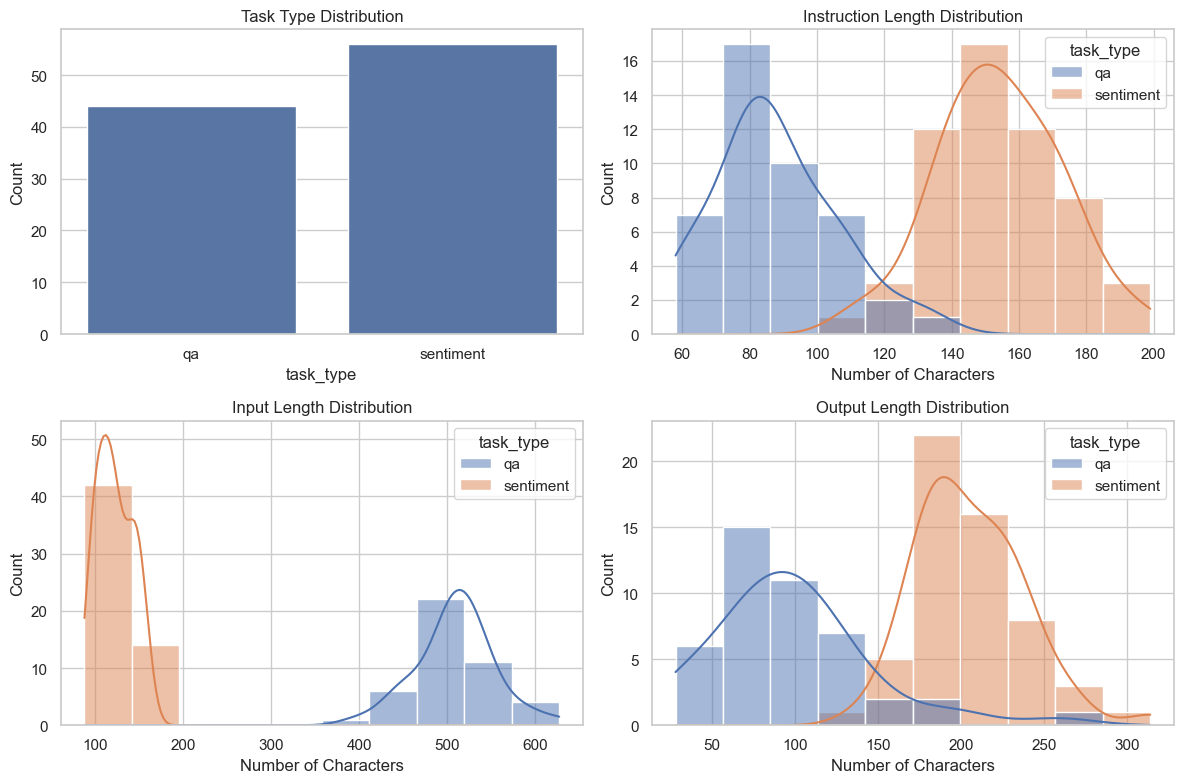

In [16]:
# Visualize Dataset Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Task type distribution
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='task_type')
plt.title('Task Type Distribution')
plt.ylabel('Count')

# Instruction length distribution
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='instruction_len', hue='task_type', bins=10, kde=True)
plt.title('Instruction Length Distribution')
plt.xlabel('Number of Characters')

# Input length distribution
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='input_len', hue='task_type', bins=10, kde=True)
plt.title('Input Length Distribution')
plt.xlabel('Number of Characters')

# Output length distribution
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='output_len', hue='task_type', bins=10, kde=True)
plt.title('Output Length Distribution')
plt.xlabel('Number of Characters')

plt.tight_layout()
# plt.savefig('dataset_analysis.png')
plt.show()


## 8. Sample Review and Inspection

Let’s randomly examine some of the generated task examples to check their quality and ensure diversity.

In [17]:
# Randomly sample a few Sentiment Analysis task examples
sentiment_samples = df[df['task_type'] == 'sentiment'].sample(n=2, random_state=42)

# Randomly sample a few QA task examples
qa_samples = df[df['task_type'] == 'qa'].sample(n=2, random_state=42)

# Display Sentiment Analysis examples
print("Sentiment Analysis Task Examples:")
for i, (_, row) in enumerate(sentiment_samples.iterrows(), 1):
    print(f"\nExample {i}:")
    print(f"Instruction: {row['instruction']}")
    print(f"Input: {row['input']}")
    print(f"Output: {row['output']}")

# Display QA examples
print("\n\nQA Task Examples:")
for i, (_, row) in enumerate(qa_samples.iterrows(), 1):
    print(f"\nExample {i}:")
    print(f"Instruction: {row['instruction']}")
    print(f"Input: {row['input']}")
    print(f"Output: {row['output']}")


Sentiment Analysis Task Examples:

Example 1:
Instruction: Determine the sentiment expressed in the following statement. Classify it as positive, negative, or neutral, providing a one-sentence explanation for your selection.
Input: “Honestly, this exhibition was a complete disaster. The artist’s choices were baffling and frankly, insulting to the viewer’s intelligence.”
Output: {"Sentiment": "negative", "Reason": "The statement uses strongly negative words like 'disaster,' 'baffling,' and 'insulting,' indicating a highly unfavorable opinion of the exhibition."}

Example 2:
Instruction: Determine the sentiment polarity of the text provided.  Categorize the sentiment as positive, negative, or neutral, providing a concise explanation for your decision.
Input: It was a quiet evening, spent mostly reading alone. I enjoyed the peace and the familiar comfort of my home.
Output: {"Sentiment": "positive", "Reason": "The text describes a pleasant experience ('quiet evening,' 'peace,' 'familiar c

## 9. Save the Dataset

Save the generated dataset in JSON format for use in fine-tuning.

In [18]:
# Remove auxiliary length columns
df_export = df.drop(columns=['instruction_len', 'input_len', 'output_len'])

# Convert to fine-tuning format
export_data = df_export.to_dict(orient='records')

# Save as JSON file
output_file = "dataset_self_instruction.json"

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(export_data, f, ensure_ascii=False, indent=2)

print(f"Dataset saved to: {output_file}")

# Save another version formatted for OpenAI fine-tuning
openai_format = []
for item in export_data:
    openai_format.append({
        "messages": [
            {
                "role": "system",
                "content": item["instruction"]
            },
            {
                "role": "user",
                "content": item["input"]
            },
            {
                "role": "assistant",
                "content": item["output"]
            }
        ]
    })

openai_output_file = "dataset_self_instruction_openai.json"
with open(openai_output_file, 'w', encoding='utf-8') as f:
    json.dump(openai_format, f, ensure_ascii=False, indent=2)

print(f"OpenAI-formatted dataset saved to: {openai_output_file}")


Dataset saved to: dataset_self_instruction.json
OpenAI-formatted dataset saved to: dataset_self_instruction_openai.json


## 10. Dataset Expansion and Improvement Suggestions

This notebook demonstrates a basic Self-Instruction workflow focused on sentiment analysis and QA tasks. To further expand and enhance this dataset, consider the following recommendations:

1. **Increase Task Type Diversity**:  
   Beyond sentiment analysis and QA, include tasks such as text classification, named entity recognition, summarization, etc.

2. **Add Complexity**:  
   Gradually incorporate more complex tasks like multi-step reasoning or comparative analysis.

3. **Improve Quality Filtering**:  
   Develop stricter quality filtering mechanisms to ensure that generated instructions are clear, inputs are appropriate, and outputs are accurate.

4. **Incorporate Human Review**:  
   As the dataset grows, introduce a human review step to assess and refine the quality of generated content.

5. **Support Multiple Languages**:  
   Expand to other languages to build a multilingual Self-Instruction dataset.

6. **Domain Specialization**:  
   Create domain-specific task sets tailored to fields like medicine, law, finance, etc.

7. **Use More Varied Text Sources**:  
   Source input texts from diverse content types and platforms to improve variety.

8. **Iterative Refinement**:  
   Use a model fine-tuned on the current Self-Instruction dataset to generate the next round of tasks, enabling progressive enhancement.

9. **Experiment with Task Distribution**:  
   Adjust the proportions of different task types to study their impact on model performance.

10. **Seed with Manually Crafted High-Quality Examples**:  
    Incorporate more high-quality, human-written seed examples to boost overall generation quality. 

Let me know if you’d like to explore any of these directions with sample code or implementation strategies.

## 11. Conclusion

Self-instruction is an effective technique that leverages a small amount of high-quality, manually labeled data to generate a large number of training examples. This notebook demonstrated the complete process of using this approach to create datasets for sentiment analysis and QA tasks.

Through this method, we can:
- Significantly reduce reliance on manual annotation  
- Rapidly generate diverse instruction–response pairs  
- Create more targeted, task-specific datasets  
- Continuously expand and update datasets over time  

This approach is particularly well-suited for fine-tuning large language models, enabling them to better follow a wide range of instructions and produce useful outputs. As model capabilities and generation quality improve, self-instruction can foster a positive feedback loop—continually enhancing the model’s ability to understand and follow instructions.